 
# 5. Toy example of a Probabilistic Movement Primitives (ProMPs) and Conditioning

In order to run this, please first download the sample data at https://github.com/sebasutp/promp/blob/master/examples/strike_mov.npz

This code is adapted from the code at https://github.com/sebasutp/promp/

### Training a ProMP

First we shall load some sample data and fit a ProMP with the learnt samples.

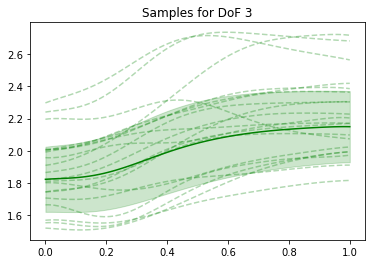

In [4]:
import intprim
from intprim.probabilistic_movement_primitives import *
import numpy as np
import matplotlib.pyplot as plt
from intprim.util.kinematics import BaseKinematicsClass


# Load the sample data from https://github.com/sebasutp/promp/blob/master/examples/strike_mov.npz
data = np.load('strike_mov.npz',allow_pickle=True,encoding='bytes')
time = data['time']
Q = data['Q']
num_joints = Q[0].shape[1]

# Create a ProMP with Gaussian basis functions.
basis_model = intprim.basis.GaussianModel(8, 0.1, ['joint'+str(i) for i in range(num_joints)])
promp = ProMP(basis_model)

# Add Demonstrations to the ProMP, which in turn calculates the list of weights for each demonstration.
for i in range(len(Q)):
	promp.add_demonstration(Q[i].T)

# Plot samples from the learnt ProMP

n_samples = 20 # Number of trajectoies to sample
plot_dof = 3 # Degree of freedom to plot
domain = np.linspace(0,1,100)

for i in range(n_samples):
	samples, _ = promp.generate_probable_trajectory(domain)
	plt.plot(domain, samples[plot_dof,:], 'g--', alpha=0.3)

mean_margs = np.zeros(samples[plot_dof,:].shape)
upper_bound = np.zeros(samples[plot_dof,:].shape)
lower_bound = np.zeros(samples[plot_dof,:].shape)
for i in range(len(domain)):
	mu_marg_q, Sigma_marg_q = promp.get_marginal(domain[i])
	std_q = Sigma_marg_q[plot_dof][plot_dof] ** 0.5
	
	mean_margs[i] = mu_marg_q[plot_dof]
	upper_bound[i] = mu_marg_q[plot_dof] + std_q
	lower_bound[i] = mu_marg_q[plot_dof] - std_q

plt.fill_between(domain, upper_bound, lower_bound, color = 'g', alpha=0.2)
plt.plot(domain, mean_margs, 'g-')
plt.title('Samples for DoF {}'.format(plot_dof))
plt.show()

### An example of Joint Space Conditioning.

Here, we want to condition the ProMP with to start at from an initial joint configuration given by `q_cond_init`.

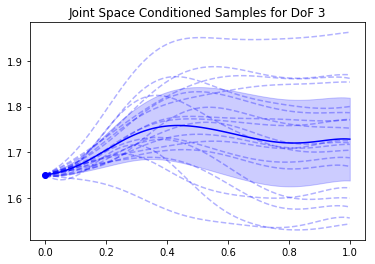

In [5]:
q_cond_init = [1.54, 0.44, 0.15, 1.65, 0.01, -0.09, -1.23]
t = 0

# Condition the ProMP and obtain the posterior distribution.
mu_w_cond, Sigma_w_cond = promp.get_conditioned_weights(t, q_cond_init)

# Plot samples of the conditioned ProMP drawn from the predicted posterior.
plt.plot(0,q_cond_init[plot_dof],'bo')
for i in range(n_samples):
	samples, _ = promp.generate_probable_trajectory(domain, mu_w_cond, Sigma_w_cond)
	plt.plot(domain, samples[plot_dof,:], 'b--', alpha=0.3)
	
for i in range(len(domain)):
	mu_marg_q, Sigma_marg_q = promp.get_marginal(domain[i], mu_w_cond, Sigma_w_cond)
	std_q = Sigma_marg_q[plot_dof][plot_dof] ** 0.5
	
	mean_margs[i] = mu_marg_q[plot_dof]
	upper_bound[i] = mu_marg_q[plot_dof] + std_q
	lower_bound[i] = mu_marg_q[plot_dof] - std_q

plt.fill_between(domain, upper_bound, lower_bound, color = 'b', alpha=0.2)
plt.plot(domain, mean_margs, 'b-')
plt.title('Joint Space Conditioned Samples for DoF {}'.format(plot_dof))
plt.show()

The blue dot in the graph shows the value that the ProMP is conditioned with.

### An example of conditioning a partially observed trajectory.

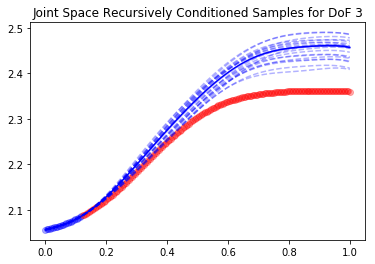

In [6]:
# First, we select a trajecotry to "observe".
q_cond = np.random.choice(Q)
q_domain = np.linspace(0, 1, len(q_cond))

# Condition the ProMP interatively and obtain the posterior distribution at each step.
mu_w_cond_rec, Sigma_w_cond_rec = promp.get_conditioned_weights(q_domain[0], q_cond[0])
num_observed = 25
for i in range(1, num_observed):
	mu_w_cond_rec, Sigma_w_cond_rec = promp.get_conditioned_weights(q_domain[i], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)
# Plot samples of the conditioned ProMP drawn from the predicted posterior.
plt.plot(q_domain[:num_observed],q_cond[:num_observed,plot_dof],'bo', alpha=0.3)
plt.plot(q_domain[num_observed:],q_cond[num_observed:,plot_dof],'ro', alpha=0.3)
for i in range(n_samples):
	samples, _ = promp.generate_probable_trajectory(domain, mu_w_cond_rec, Sigma_w_cond_rec)
	plt.plot(domain, samples[plot_dof,:], 'b--', alpha=0.3)

mean_margs = np.zeros(samples[plot_dof,:].shape)
upper_bound = np.zeros(samples[plot_dof,:].shape)
lower_bound = np.zeros(samples[plot_dof,:].shape)
std_Q = []
for i in range(len(domain)):
	mu_marg_q, Sigma_marg_q = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
	std_q = Sigma_marg_q[plot_dof][plot_dof]
	std_Q.append(std_q)
	mean_margs[i] = mu_marg_q[plot_dof]
	upper_bound[i] = mu_marg_q[plot_dof] + std_q
	lower_bound[i] = mu_marg_q[plot_dof] - std_q
plt.fill_between(domain, upper_bound, lower_bound, color = 'b', alpha=0.2)
plt.plot(domain, mean_margs, 'b-')
plt.title('Joint Space Recursively Conditioned Samples for DoF {}'.format(plot_dof))
plt.show()

The red trajectory shows the full observed trajectory. The blue dots in the beginning are the values that the ProMP is conditioned with.

### An example of Task Space Conditioning.

First, we need to define the Kinematics of the robot, which in this case is a Barrett WAM.

In [7]:
class BarrettKinematics(BaseKinematicsClass):
	''' Forward kinematics object for the Barrett Wam
	This class implements the forwark kinematics functionality for the
	Barrett Wam arm used in the table tennis setup at the MPI. The end
	effector position can be changes with the endeff parameter received
	in the constructor.

	The code is taken from https://github.com/sebasutp/promp/blob/master/robpy/kinematics/forward.py
	'''

	def __init__(self, endeff = [0.0, 0.0, 0.3, 0.0, 0.0, 0.0]):
		self.ZSFE = 0.346
		self.ZHR = 0.505
		self.YEB = 0.045
		self.ZEB = 0.045
		self.YWR = -0.045
		self.ZWR = 0.045
		self.ZWFE = 0.255
		self.endeff = endeff

	def _link_matrices(self,q):
		cq = np.cos(q)
		sq = np.sin(q)

		sa=np.sin(self.endeff[3])
		ca=np.cos(self.endeff[3])

		sb=np.sin(self.endeff[4])
		cb=np.cos(self.endeff[4])

		sg=np.sin(self.endeff[5])
		cg=np.cos(self.endeff[5])

		hi00 = np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
		hi01 = np.array([[cq[0],-sq[0],0,0],[sq[0],cq[0],0,0],[0,0,1,self.ZSFE],[0,0,0,1]])
		hi12 = np.array([[0,0,-1,0],[sq[1],cq[1],0,0],[cq[1],-sq[1],0,0],[0,0,0,1]])
		hi23 = np.array([[0,0,1,self.ZHR],[sq[2],cq[2],0,0],[-cq[2],sq[2],0,0],[0,0,0,1]])
		hi34 = np.array([[0,0,-1,0],[sq[3],cq[3],0,self.YEB],[cq[3],-sq[3],0,self.ZEB],[0,0,0,1]])
		hi45 = np.array([[0,0,1,self.ZWR],[sq[4],cq[4],0,self.YWR],[-cq[4],sq[4],0,0],[0,0,0,1]])
		hi56 = np.array([[0,0,-1,0],[sq[5],cq[5],0,0],[cq[5],-sq[5],0,self.ZWFE],[0,0,0,1]])
		hi67 = np.array([[0,0,1,0],[sq[6],cq[6],0,0],[-cq[6],sq[6],0,0],[0,0,0,1]])
		hi78 = np.array([[cb*cg, -(cb*sg), sb, self.endeff[0]], \
			[cg*sa*sb + ca*sg, ca*cg - sa*sb*sg, -(cb*sa), self.endeff[1]], \
			[-(ca*cg*sb) + sa*sg, cg*sa + ca*sb*sg, ca*cb, self.endeff[2]], \
			[0,0,0,1]])
		return [hi00,hi01,hi12,hi23,hi34,hi45,hi56,hi67,hi78]

Next we calculate the configuration to reach the 3D point parametrized by `mu_cartesian` and `Sigma_cartesian`.

fun: 1.2607255597690448
 hess_inv: array([[ 0.00572446,  0.00044346, -0.00582389, -0.00205088, -0.00312282,
         0.00545993,  0.00661536],
       [ 0.00044346,  0.0014325 , -0.00066501, -0.00146189, -0.00108719,
         0.00078602,  0.00159786],
       [-0.00582389, -0.00066501,  0.00683648,  0.00209646,  0.00510573,
        -0.00521655, -0.00925261],
       [-0.00205088, -0.00146189,  0.00209646,  0.00539554,  0.00688907,
        -0.00790783, -0.00856472],
       [-0.00312282, -0.00108719,  0.00510573,  0.00688907,  0.09056763,
        -0.01234715, -0.10080951],
       [ 0.00545993,  0.00078602, -0.00521655, -0.00790783, -0.01234715,
         0.01772946,  0.01689341],
       [ 0.00661536,  0.00159786, -0.00925261, -0.00856472, -0.10080951,
         0.01689341,  0.12345578]])
      jac: array([-3.86583891e-06,  8.02217272e-06, -4.46214839e-06,  3.75499468e-06,
       -2.51596661e-07,  1.66831373e-06, -2.80330763e-07])
  message: 'Optimization terminated successfully.'
     nfev: 2

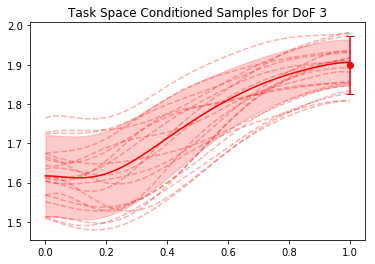

In [8]:
mu_cartesian = np.array([-0.62, -0.44, -0.34])
Sigma_cartesian = 0.02**2*np.eye(3)

# Get the prior distribution of the joint space at the desired time.
t = 1
prior_mu_q, prior_Sigma_q = promp.get_marginal(t)

# Compute the posterior distribution of the joint space using inverse kinematics.
fwd_kin = BarrettKinematics()
mu_q, Sigma_q = fwd_kin.inv_kin(prior_mu_q, prior_Sigma_q, mu_cartesian, Sigma_cartesian)

# Finally, condition the ProMP using the posterior joint space distribution.
mu_w_task, Sigma_w_task = promp.get_conditioned_weights(t, mu_q, Sigma_q)

# Plot samples of the conditioned ProMP.
std_q = Sigma_q[plot_dof][plot_dof] ** 0.5
plt.errorbar(t, mu_q[plot_dof], yerr=std_q, color='r', fmt='--o', capsize=4)
for i in range(n_samples):
	samples, _ = promp.generate_probable_trajectory(domain, mu_w_task, Sigma_w_task)
	plt.plot(domain, samples[plot_dof,:], 'r--', alpha=0.3)

for i in range(len(domain)):
	mu_marg_q, Sigma_marg_q = promp.get_marginal(domain[i], mu_w_task, Sigma_w_task)
	std_q = Sigma_marg_q[plot_dof][plot_dof] ** 0.5
	
	mean_margs[i] = mu_marg_q[plot_dof]
	upper_bound[i] = mu_marg_q[plot_dof] + std_q
	lower_bound[i] = mu_marg_q[plot_dof] - std_q

plt.fill_between(domain, upper_bound, lower_bound, color = 'r', alpha=0.2)
plt.plot(domain, mean_margs, 'r-')
plt.title('Task Space Conditioned Samples for DoF {}'.format(plot_dof))
plt.show()

The red errorbar in the graph shows the posterior of the joint space  that the ProMP is conditioned with, obtained using inverse kinematics.

### An example combining both Joint Space and Task Space Conditioning.

fun: 8.523225059594797
 hess_inv: array([[ 1.01800110e-03, -1.20595501e-04, -6.83124829e-04,
        -5.64921023e-04, -9.38689511e-04,  1.59783831e-03,
         9.30587100e-04],
       [-1.20595501e-04,  1.04708066e-03,  5.92601574e-05,
        -9.64160900e-04, -1.60155857e-04, -1.52791383e-04,
        -4.77393770e-04],
       [-6.83124829e-04,  5.92601574e-05,  9.69966172e-04,
         7.33882826e-04,  1.17225949e-03, -1.62170575e-03,
        -1.06071838e-03],
       [-5.64921023e-04, -9.64160900e-04,  7.33882826e-04,
         3.39727882e-03,  2.16358794e-03, -3.74108595e-03,
        -8.43872132e-04],
       [-9.38689511e-04, -1.60155857e-04,  1.17225949e-03,
         2.16358794e-03,  5.51992232e-03, -3.75680107e-03,
        -5.16995427e-03],
       [ 1.59783831e-03, -1.52791383e-04, -1.62170575e-03,
        -3.74108595e-03, -3.75680107e-03,  8.96353720e-03,
         2.73836754e-03],
       [ 9.30587100e-04, -4.77393770e-04, -1.06071838e-03,
        -8.43872132e-04, -5.16995427e-03,  

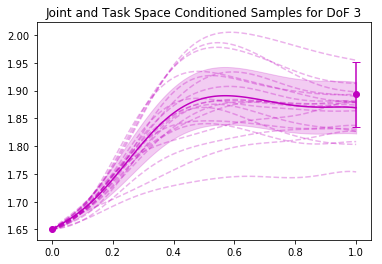

In [9]:
t = 0

# First condition the ProMP in the joint space.
mu_w_cond, Sigma_w_cond = promp.get_conditioned_weights(t, q_cond_init)
plt.plot(0,q_cond_init[plot_dof],'mo')

# Get the prior distribution of the joint space from the conditioned ProMP.
t = 1
prior_mu_q, prior_Sigma_q = promp.get_marginal(t, mu_w_cond, Sigma_w_cond)

# Compute the posterior distribution of the joint space using inverse kinematics.
mu_q, Sigma_q = fwd_kin.inv_kin(prior_mu_q, prior_Sigma_q, mu_cartesian, Sigma_cartesian)

# Finally, condition the ProMP using the posterior joint space distribution.
mu_w_task, Sigma_w_task = promp.get_conditioned_weights(t, mu_q, Sigma_q, mu_w_cond, Sigma_w_cond)

# Plot samples of the conditioned ProMP.
std_q = Sigma_q[plot_dof][plot_dof] ** 0.5
plt.errorbar(t, mu_q[plot_dof], yerr=std_q, color='m', fmt='--o', capsize=4)
for i in range(n_samples):
	samples, _ = promp.generate_probable_trajectory(domain, mu_w_task, Sigma_w_task)
	plt.plot(domain, samples[plot_dof,:], 'm--', alpha=0.3)

for i in range(len(domain)):
	mu_marg_q, Sigma_marg_q = promp.get_marginal(domain[i], mu_w_task, Sigma_w_task)
	std_q = Sigma_marg_q[plot_dof][plot_dof] ** 0.5
	
	mean_margs[i] = mu_marg_q[plot_dof]
	upper_bound[i] = mu_marg_q[plot_dof] + std_q
	lower_bound[i] = mu_marg_q[plot_dof] - std_q

plt.fill_between(domain, upper_bound, lower_bound, color = 'm', alpha=0.2)
plt.plot(domain, mean_margs, 'm-')
plt.title('Joint and Task Space Conditioned Samples for DoF {}'.format(plot_dof))
plt.show()